# Import

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import shutil
import glob
import h5py

from os.path import isfile, join
from os import listdir
from PIL import Image
from skimage import io, color
from skimage.transform import resize

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception
from tensorflow.compat.v1.data import make_one_shot_iterator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,14))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,0.3))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [ ]:
def store_many_hdf5(images, lables):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """

    # Create a new HDF5 file
    file = h5py.File('/content/drive/MyDrive/Colab Notebooks/recipify/data/val_data.h5', "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), data=images)
    
    meta_set = file.create_dataset(
        "meta", np.shape(lables), data=lables)
    file.close()

# Import data subset as zip

In [ ]:
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/recipify/raw_data/train_subset_150.zip', "./data_new/")

In [ ]:
train_dir = "./data_new/train_subset_150/*jpg"

In [ ]:
pathes_train = glob.glob(train_dir)
len(pathes_train)

37534

# Transforming images into numpy arrays



In [ ]:
# extracting images as numpy arrays
test_list = []

for idx, filename in enumerate(pathes_train):
    rgb = io.imread(filename)
    rgb = resize(rgb, (128, 128))
    test_list.append(rgb)

In [ ]:
# stack np arrays
X_train_arr = np.stack(test_list, axis=0)
X_train_arr.shape

(37534, 128, 128, 3)

In [ ]:
# transform into tensor
X_train = tf.convert_to_tensor(X_train_arr)

In [ ]:
# extract labels for train data
colnames = ['img_name', 'label']
train_path = "./labels/train_info.csv"
train_df = pd.read_csv(train_path, names = colnames,  header = None)
train_df

In [ ]:
# extract labels for subset
relative_path = './data_new/train_subset_150'
train_lables = pd.DataFrame(columns=colnames)

for path in pathes_train:
    im_name = os.path.relpath(path, relative_path)
    train_lables = train_lables.append(train_df[train_df['img_name']==im_name])

In [ ]:
# labels into array
y_train_arr = train_lables["label"].to_numpy()
y_train_arr.shape

(37534,)

In [ ]:
# labels into tensor
y_train_arr = np.asarray(y_train_arr).astype('float32')
y_train = tf.convert_to_tensor(y_train_arr)

In [ ]:
# save the dataset
store_many_hdf5(X_train_arr, y_train_arr)

# Model

In [ ]:
# one hot encoder for labels
y_cat = to_categorical(y_train)

(37534, 251)

In [ ]:
n_classes = 251
batch_size = 128
input_shape = (128, 128, 3)

In [ ]:
# layers
inputs = Input(shape = input_shape)
flip = RandomFlip("horizontal_and_vertical")
rot = RandomRotation(1/12)
crop = RandomCrop(128, 128)

xception = Xception(weights='imagenet', include_top=False)
xception.trainable = True 

flat = Flatten()
dense = Dense(128, kernel_regularizer=l1_l2(), activation='relu')
dropout = Dropout(0.2)
output = Dense(n_classes, activation='softmax')

xception_model = models.Sequential([inputs, flip, rot, crop, xception, flat, dense, dropout, output])
xception_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xception_model.summary()

In [ ]:
es = EarlyStopping(patience=20, restore_best_weights=True, monitor='accuracy')
cp = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/recipify/data/xception_save_at_{epoch}.keras")
callbacks_1 = [es, cp]

history_xception = xception_model.fit(X_train, y_cat, 
                    validation_split = 0.3,
                    batch_size = batch_size,
                    epochs=300,
                    verbose=1,
                    callbacks = callbacks_1)

In [ ]:
xception_model.save('/content/drive/MyDrive/Colab Notebooks/recipify/data/xception_model_best.h5')

In [ ]:
plot_loss_accuracy(history_xception, title=None)

# Predictions

In [ ]:
loaded_model = models.load_model("/content/drive/MyDrive/Colab Notebooks/recipify/data/xception_model_best.keras")

In [ ]:
filename = "ice.jpg"
test_image = io.imread(filename)
test_image = resize(test_image, (128, 128))
test_image = tf.convert_to_tensor(test_image)


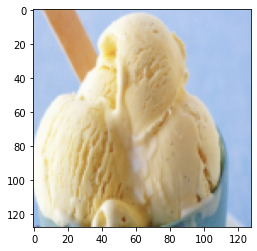

In [ ]:
plt.imshow(test_image);

In [ ]:
test_image = tf.expand_dims(test_image, axis=0)

In [ ]:
pred = loaded_model.predict(test_image)
prediction = pd.DataFrame(pred, columns= range(251))
prediction = prediction.T
prediction = round(prediction.sort_values(by=0), 5)

In [ ]:
prediction